# 주제: CNN을 이용한 Image Localization 구현하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 Oxford-IIIT Pet dataset을 사용합니다.
    - Oxford-IIIT Pet dataset은 37종의 개, 고양이로 구성된 dataset입니다.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
    - 모든 데이터의 이름은 class_name.(확장자)로 구성되어 있으며 class_name의 첫 알파벳이 대문자이면 '고양이', 소문자이면 '개'입니다.

    1. images
      - image 데이터들이 포함되어 있음
      - 확장자는 모두 jpg임
      - RGB이미지 외에도 Gray scale이나 RGBA 이미지도 함께 포함되어 있음
    2. annotations/xmls
      - localization을 위한 bounding-box 위치 정보가 포함되어 있음
      - image의 width, height 등 기타 다른 정보도 함께 저장되어 있음
      - 확장자는 모두 xml임
    3. annotations/trimaps
      - segmentation을 위한 segmentation map이 포함되어 있음
      - 확장자는 모두 png임
      - 이번 실습에서는 사용하지 않음

- 원본 데이터 출처: https://www.robots.ox.ac.uk/~vgg/data/pets/

## 문제 소개
    - 이번 실습에서는 head ROI 정보를 이용하여 개와 고양이의 머리 부분을 찾는(localization) network을 design하고 학습해 보도록 하겠습니다.

## 최종 목표
    - tfrecord 파일 작성 방법 이해
    - pre-trained CNN 활용 방법 이해
    - CNN을 활용한 localization model 작성
    - multi-task learning을 이용한 성능 향상 방법 습득

- 출제자: 이진원 강사

## Step 1. 데이터 다운로드 및 전처리

In [1]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import gdown

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(zip 파일)
    - gdown library를 이용하여 data를 다운받고, zip파일 압축을 풀어줍니다.
    - 압축 파일은 oxford_pet이라는 이름의 directory에 풀도록 합니다.

In [2]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=7a8b8f34bbe77e25d84854874f3c14350c16e14ac5ebce51513e09245f82a542
  Stored in directory: /tmp/pip-ephem-wheel-cache-805xow7q/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [3]:
data_url = "https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0"

In [4]:
## data download 받기(gdown.download 사용)
##### CODE HERE #####
# gdown.download(data_url, 'oxford_pet.zip', quiet=False)
!gdown --id '1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'

## oxford_pet directory에 압축풀기
##### CODE HERE #####
!unzip -q oxford_pet.zip -d oxford_pet

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
100% 811M/811M [00:14<00:00, 54.1MB/s]


In [5]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


### 문제 2. 이미지 데이터와 bounding box 데이터 갯수 확인

    - image data는 images directory에, bounding box 정보는 annotations/xmls directory에 있습니다.
    - image data의 확장자는 .jpg이고, bounding box 정보가 있는 파일은 .xml입니다.
    - 각각의 directory에서 .jpg파일의 수(n_images) .xmls 파일의 수(n_bboxes)를 확인해봅니다.

In [6]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')

In [7]:
## image file 수 확인
##### CODE HERE #####
import glob
a = glob.glob(os.path.join(image_dir, "*.jpg"))
files = list(a)
print(len(files))

7390


In [8]:
files

['/content/oxford_pet/images/miniature_pinscher_128.jpg',
 '/content/oxford_pet/images/havanese_84.jpg',
 '/content/oxford_pet/images/Maine_Coon_174.jpg',
 '/content/oxford_pet/images/Birman_143.jpg',
 '/content/oxford_pet/images/Egyptian_Mau_170.jpg',
 '/content/oxford_pet/images/english_cocker_spaniel_55.jpg',
 '/content/oxford_pet/images/keeshond_11.jpg',
 '/content/oxford_pet/images/beagle_71.jpg',
 '/content/oxford_pet/images/Ragdoll_252.jpg',
 '/content/oxford_pet/images/Sphynx_138.jpg',
 '/content/oxford_pet/images/havanese_176.jpg',
 '/content/oxford_pet/images/Sphynx_87.jpg',
 '/content/oxford_pet/images/japanese_chin_131.jpg',
 '/content/oxford_pet/images/english_setter_117.jpg',
 '/content/oxford_pet/images/english_setter_177.jpg',
 '/content/oxford_pet/images/basset_hound_59.jpg',
 '/content/oxford_pet/images/english_setter_172.jpg',
 '/content/oxford_pet/images/english_cocker_spaniel_46.jpg',
 '/content/oxford_pet/images/english_cocker_spaniel_164.jpg',
 '/content/oxford_p

In [9]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
n_images = len(image_files)
print(n_images)

7390


In [10]:
## localization을 위한 bounding box 정보가 있는 xml file의 수 확인
##### CODE HERE #####
a = glob.glob(os.path.join(bbox_dir, "*.xml"))
boxs = list(a)
print(len(boxs))

3686


In [11]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3686


In [12]:
bbox_files

['keeshond_160.xml',
 'Bengal_149.xml',
 'keeshond_11.xml',
 'chihuahua_166.xml',
 'saint_bernard_107.xml',
 'newfoundland_13.xml',
 'saint_bernard_139.xml',
 'British_Shorthair_155.xml',
 'english_setter_178.xml',
 'staffordshire_bull_terrier_175.xml',
 'saint_bernard_162.xml',
 'Bombay_14.xml',
 'great_pyrenees_108.xml',
 'pug_173.xml',
 'saint_bernard_141.xml',
 'scottish_terrier_179.xml',
 'Ragdoll_104.xml',
 'shiba_inu_14.xml',
 'saint_bernard_173.xml',
 'keeshond_175.xml',
 'pug_121.xml',
 'Bengal_151.xml',
 'leonberger_104.xml',
 'leonberger_185.xml',
 'wheaten_terrier_184.xml',
 'Birman_179.xml',
 'chihuahua_116.xml',
 'basset_hound_15.xml',
 'pug_187.xml',
 'english_cocker_spaniel_137.xml',
 'english_setter_134.xml',
 'great_pyrenees_126.xml',
 'american_bulldog_180.xml',
 'Abyssinian_158.xml',
 'miniature_pinscher_178.xml',
 'german_shorthaired_137.xml',
 'leonberger_163.xml',
 'saint_bernard_168.xml',
 'newfoundland_120.xml',
 'Russian_Blue_173.xml',
 'Persian_186.xml',
 'Sp

In [13]:
os.path.split(boxs[0])[-1]

'keeshond_160.xml'

### 문제 3. 데이터 확인하기

    - 임의의 image file과 bounding box 정보를 읽어서 화면에 출력해봅시다.
    - image file은 numpy array형태로 image라는 변수에 저장합니다.
    - bounding box 정보를 위하여, xml.etree.ElementTree library를 활용하여 xml 파일을 parsing합니다.
    - bounding box는 matplotlib.patches의 Rectangle을 이용합니다.
    - 이를 위하여 필요한 bounding box의 좌측 상단 좌표(x,y)와 width, height는 각각 (rect_x, rect_y)로, rect_w, rect_h로 저장합니다.    

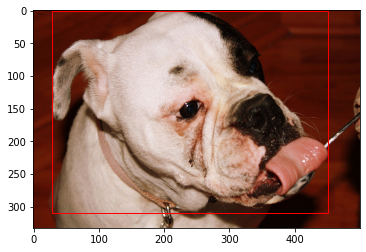

In [14]:
##### CODE HERE #####
idx = random.randint(0, len(boxs)-1)

bbox_name = os.path.split(boxs[idx])[-1]
bbox_path = os.path.join(bbox_dir, bbox_name)
tree = et.parse(bbox_path)

x_min = float(tree.find("./object/bndbox/xmin").text)
x_max = float(tree.find("./object/bndbox/xmax").text)
y_min = float(tree.find("./object/bndbox/ymin").text)
y_max = float(tree.find("./object/bndbox/ymax").text)

rect_x = x_min
rect_y = y_min
rect_w = x_max - x_min
rect_h = y_max - y_min

file_name = os.path.splitext(bbox_name)[0] + ".jpg"
file_path = os.path.join(image_dir, file_name)
image = Image.open(file_path)
image = np.array(image)

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

### 문제 4. RGB 외의 data 삭제하기

    - image 파일 중에는 채널 수가 3이 아닌 즉 RGB가 아닌 형태의 파일들이 존재합니다.
    - 채널 수가 3이 아닌 경우에는 따로 처리를 해주어야 하는 불편함이 있으므로 RGB 외의 image는 삭제합니다.
    - PIL.Image library에서는 image의 mode를 제공하는데, 이를 이용하여 RGB가 아닌 image를 삭제할 수 있습니다.
    - 이때 같은 이름을 갖는 bounding box file도 같이 삭제하도록 합시다. (예: aaa.jpg 파일 삭제 시에 aaa.xml 파일도 같이 삭제)

In [15]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
##### CODE HERE #####
for f in files:
    file_name = os.path.split(f)[-1]
    bbox_name = os.path.splitext(file_name)[0] + ".xml"
    bbox_path = os.path.join(bbox_dir, bbox_name)

    image = Image.open(f)
    image_mode = image.mode

    if image_mode != "RGB":
        print(file_name, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(f)
        try:
            os.remove(bbox_path)
        except FileNotFoundError :
            pass


Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_129.jpg L
(325, 299)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_167.jpg P
(275, 183)
Abyssinian_34.jpg P
(202, 250)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_191.jpg P
(214, 300)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_139.jpg P
(250, 350)


    - 다시 위의 문제 2번에서 확인했던 image file 수와 xml file 수를 확인해봅니다.
    - image file은 7378개, xml file은 3685개가 나오는지 확인합니다.
    - 나중에 활용하기 위해 image file과 xml file의 file명을 담은 list를 각각 만들어둡니다.

In [16]:
## image file 수 확인
##### CODE HERE #####
a = glob.glob(os.path.join(image_dir, "*.jpg"))
files = list(a)
print(len(files))

7378


In [17]:
## localization을 위한 bounding box 정보가 있는 xml file의 수 확인
##### CODE HERE #####
a = glob.glob(os.path.join(bbox_dir, "*.xml"))
boxs = list(a)
print(len(boxs))

3685


## Step 2. tfrecord 파일 만들기

    - tfrecord file은 protocal buffer 형태의 binary file입니다.
    - image와 bounding box정보를 tfrecord file 형태로 저장해보겠습니다.

    - tfrecord file을 만드는 방법은 아래 링크를 참고하면 됩니다.
https://www.tensorflow.org/tutorials/load_data/tfrecord




### 문제 5. train/validation data 나누기

    - tfrecord 파일로 저장할 때 모든 image는 224x224로 resize하여 저장합니다.
    - 전체 bounding box file(.xml)수가 3685개 이므로 image file수는 더 많다고 하더라도 이 3685개 data만 활용하도록 하겠습니다.
    - 이 중에 training set으로 3000개, validation set으로 나머지 685개를 사용합니다.
    - test set은 따로 구성하지 않고, 나중에 인터넷에서 임의의 사진을 down받아서 확인하는 것으로 대신합니다.

In [18]:
## 필요한 상수들
IMG_SIZE = 224
N_DATA = 3685
N_TRAIN = 3000
N_VAL = 685

    - bounding box file 중에 random하게 3000개를 뽑아서 training set, 나머지는 validation set으로 사용합니다.
    - bounding box file과 같은 이름(확장자는 .jpg)을 갖는 image file도 똑같이 training set과 validation set으로 나눕니다.
    - 이 때 image file과 xml file의 list를 가지고 있는 경우 index를 random으로 3000개, 685개로 뽑아서 활용하면 편합니다.

In [19]:
## train/validation data 나누기
##### CODE HERE #####
list_ = list(range(N_DATA))
random.shuffle(list_)

train_idx_list = list_[:N_TRAIN]
val_idx_list = list_[N_TRAIN:]

### 문제 6. tfrecord writer 생성

    - training과 validation data를 위한 tfrecord file의 경로 및 파일명을 각각 설정합니다.
    - 각각의 tfrecord file을 write하기 위한 writer를 생성합니다.(tf.io.TFRecordWriter 사용)

In [20]:
## TFRecord 저장할 directory와 file 경로 설정
##### CODE HERE(optional) #####
tfr_dir = os.path.join(data_dir, "tfrecord")
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'val.tfr')

In [21]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

    - tfrecord file을 작성할 때 아래 3개의 함수를 사용하여 표준 TensorFlow 유형을 tf.train.Example 호환 tf.train.Feature로 변환합니다. (from TensorFlow hompage)

In [22]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

### 문제 7. training용 tfrecord 파일 작성

    - training data에서 image와 bounding box 정보를 하나씩 읽어서 tfrecord writer를 이용하여 tfrecord file에 write합니다.
    - 이 때, image는 bytes feature 형태로 저장합니다. (위 3개 함수 중 맨 위 함수 사용)
    - bounding box 정보는 bounding box의 center 좌표(x, y)와 width, height 이 4개의 숫자를 각각 floating point로 저장합니다.
    - 이 때, x, y, width, height 값을 image의 width와 height로 나누어 모두 0에서 1 사이의 값이 되도록 합니다.
    - 추가로 개를 0번 class, 고양이를 1번 class로 하여 class label도 tfrecord 파일에 같이 저장합니다(int type 사용)
    - 이 class 정보는 뒤에서 multi-task learning을 활용할 때 사용하게 됩니다.
    - 개는 파일명의 첫 알파벳이 소문자이고, 고양이는 대문자이기 때문에 이를 이용하여 구분할 수 있습니다.
    - ((중요)) tfrecord file을 저장할 때 feature의 key 값은 다음과 같은 이름을 사용합니다.
      - 'image': image
      - 'cls_num': 개/고양이 class 번호
      - 'x': bounding box의 center x 좌표
      - 'y': bounding box의 center y 좌표
      - 'w': bounding box의 width
      - 'h': bounding box의 height
    - ((주의)) training data를 모두 tfrecord file에 write한 후에는 반드시 writer를 close 합니다.

In [23]:
for idx in train_idx_list:
    bbox_path = boxs[idx]
    bbox_file = os.path.split(bbox_path)[-1]

    tree = et.parse(bbox_path)
    width = float(tree.find("./size/width").text)
    height = float(tree.find("./size/height").text)
    xmin = float(tree.find("./object/bndbox/xmin").text)
    xmax = float(tree.find("./object/bndbox/xmax").text)
    ymin = float(tree.find("./object/bndbox/ymin").text)
    ymax = float(tree.find("./object/bndbox/ymax").text)

    cx = ((xmin + xmax) / 2.) / width
    cy = ((ymin + ymax) / 2.) / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    file_name = os.path.splitext(bbox_file)[0]
    image_file =  file_name + ".jpg"
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    if file_name[0].islower:
        cls_num = 0
    else:
        cls_num = 1

  
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),      
        'cls_num': _int64_feature(cls_num),
        'x': _float_feature(cx),
        'y': _float_feature(cy),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_train.write(example.SerializeToString())

writer_train.close()

### 문제 8. validation용 tfrecord 파일 작성

    - validation data에서 image와 bounding box 정보를 하나씩 읽어서 tfrecord writer를 이용하여 tfrecord file에 write합니다.
    - 이 때, image는 bytes feature 형태로 저장합니다. (위 3개 함수 중 맨 위 함수 사용)
    - bounding box 정보는 bounding box의 center 좌표(x, y)와 width, height 이 4개의 숫자를 각각 floating point로 저장합니다.
    - 이 때, x, y, width, height 값을 image의 width와 height로 나누어 모두 0에서 1 사이의 값이 되도록 합니다.
    - 추가로 개를 0번 class, 고양이를 1번 class로 하여 class label도 tfrecord 파일에 같이 저장합니다(int type 사용)
    - 이 class 정보는 뒤에서 multi-task learning을 활용할 때 사용하게 됩니다.
    - 개는 파일명의 첫 알파벳이 소문자이고, 고양이는 대문자이기 때문에 이를 이용하여 구분할 수 있습니다.
    - ((중요)) tfrecord file을 저장할 때 feature의 key 값은 다음과 같은 이름을 사용합니다.
      - 'image': image
      - 'cls_num': 개/고양이 class 번호
      - 'x': bounding box의 center x 좌표
      - 'y': bounding box의 center y 좌표
      - 'w': bounding box의 width
      - 'h': bounding box의 height
    - ((주의)) validation data를 모두 tfrecord file에 write한 후에는 반드시 writer를 close 합니다.

In [24]:
for idx in val_idx_list:
    bbox_path = boxs[idx]
    bbox_file = os.path.split(bbox_path)[-1]

    tree = et.parse(bbox_path)
    width = float(tree.find("./size/width").text)
    height = float(tree.find("./size/height").text)
    xmin = float(tree.find("./object/bndbox/xmin").text)
    xmax = float(tree.find("./object/bndbox/xmax").text)
    ymin = float(tree.find("./object/bndbox/ymin").text)
    ymax = float(tree.find("./object/bndbox/ymax").text)

    cx = ((xmin + xmax) / 2.) / width
    cy = ((ymin + ymax) / 2.) / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    file_name = os.path.splitext(bbox_file)[0]
    image_file =  file_name + ".jpg"
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    if file_name[0].islower:
        cls_num = 0
    else:
        cls_num = 1

  
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),      
        'cls_num': _int64_feature(cls_num),
        'x': _float_feature(cx),
        'y': _float_feature(cy),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

In [25]:
raw_dataset = tf.data.TFRecordDataset(tfr_train_dir)
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "cls_num"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "h"
    value {
      float_list {
        value: 0.18018017709255219
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\256nG\267sI\233b>T.\036]>0\231\200r\221~l<+\"^7$\240_0\240`:\207P0\203N0\226W4\251i:\250i8\256m>\237]8\233qb\254vV\246e8\234mLN1\030qZP\321\273\254\310\263\242l\\J\\:,\250pE\231gH\224hF\224dP\223bN\225_A\234]>\225oa\214J\"x4\016|4\016\213I\031\220N\033\212F\025\206B\030r+\013w2\022|5\023w/\021d#\rg%\rb!\nY\033\014W\032\006S\026\nU\034\nX\030\005V\030\003[\035\006^\035\006c\"\007g$\te%\013h+\007i*\ne(\006h+\r|;\020{9\013|:\014v7\014y8\020\216L\027\212L\022\203D\023\201A\022\202B\023\206H\023\203E\020\205F\021\204E\022\201C\020\177?\027q2\023\201B\020\207H\025\200A\013\211H\021{7\021\222`M\243u]\234\\-\235]\'\235]&\231\\&\233](\231Z$\226X\'\227W!=\031\nnieqG*\213H\025\211H\025\213L\030\213M\036\225V

## Step 3. Image Localization 모델 작성 및 학습

    - 저장한 tfrecord 파일을 읽어서, dataset을 구성하고, neural network model을 만들어서 localization을 학습해봅시다.
    - 사용할 hyper parameter 값들은 아래와 같이 정해두었으나, 변경 가능합니다.

In [26]:
## Hyper Parameters
N_EPOCHS = 40
N_BATCH = 40
N_VAL_BATCH = 137
learning_rate = 0.0001

### 문제 9. tfrecord 파일을 활용하여 train/validation dataset 만들기(tf.data)

    - tfrecord file을 읽어서 tf.data를 활용하여 model에 data를 공급해주기 위한 dataset을 만듭니다.(tf.data.TFRecordDataset 활용)
    - 이 때 아래에 작성된 _parse_function을 사용합니다.  
    - train dataset의 이름은 train_dataset으로, validation dataset의 이름은 val_dataset으로 합니다.


In [27]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),              
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [28]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(buffer_size=N_DATA).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH)

In [29]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function).batch(N_VAL_BATCH)

### 문제 10. dataset 확인

      - dataset이 제대로 만들어졌는지 확인하기 위해, validation dataset에서 첫번째 data와 label을 가져와서 image와 bounding box를 화면에 출력해봅니다.

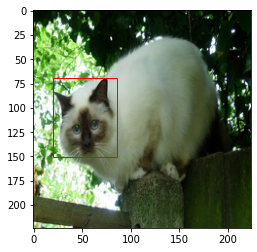

0.239 20
0.4969697 69
0.298 66
0.36969697 82


In [30]:
## validation dataset에서 첫번째 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(1):
      
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    ##### CODE HERE #####
    x = gt[:, 0][0].numpy()
    y = gt[:, 1][0].numpy()
    w = gt[:, 2][0].numpy()
    h = gt[:, 3][0].numpy()

    xmin = x - w/2
    ymin = y - h/2
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w * IMG_SIZE)
    rect_h = int(h * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()
    print(x, rect_x)
    print(y, rect_y)
    print(w, rect_w)
    print(h, rect_h)

### 문제 11. CNN으로 Localization scratch부터 학습하기

    - 간단한 형태의 CNN을 하나 만들고, scratch부터 학습해봅니다.
    - CNN의 구조는 자유롭게 만들어도 좋습니다.
    - loss는 MSE를 사용합니다.
    - optimizer도 자유롭게 선택합니다.
    - learning rate을 포함하여 필요한 hyper parameter는 조정해도 좋습니다.

In [31]:
# Sequential API를 사용하여 model 구성
from keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

def create_model():
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    x = Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = MaxPool2D(padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = MaxPool2D(padding="same")(x)
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = MaxPool2D(padding="same")(x)
    x = Conv2D(256, 3, activation="relu", padding="same")(x)
    x = MaxPool2D(padding="same")(x)
    x = Conv2D(256, 3, activation="relu", padding="same")(x)
    x = MaxPool2D(padding="same")(x)
    # x = GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.4)(x)
    outputs = Dense(4, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    return model

## Create model, compile & summary
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

In [32]:
def loss_fn(y_true, y_pred):
  return keras.losses.MeanSquaredError()(y_true, y_pred)

## learning rate scheduling(필요시), model.compile
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=N_TRAIN/N_BATCH*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [ ]:
## Train!
##### CODE HERE #####
model.fit(train_dataset, epochs=N_EPOCHS, validation_data=val_dataset)

Epoch 1/40
75/75 [==============================] - 19s 224ms/step - loss: 0.0241 - val_loss: 0.0232
Epoch 2/40
75/75 [==============================] - 18s 221ms/step - loss: 0.0234 - val_loss: 0.0232
Epoch 3/40
75/75 [==============================] - 18s 222ms/step - loss: 0.0228 - val_loss: 0.0217
Epoch 4/40
75/75 [==============================] - 18s 222ms/step - loss: 0.0218 - val_loss: 0.0205
Epoch 5/40
75/75 [==============================] - 18s 222ms/step - loss: 0.0201 - val_loss: 0.0194
Epoch 6/40
75/75 [==============================] - 18s 222ms/step - loss: 0.0188 - val_loss: 0.0182
Epoch 7/40
75/75 [==============================] - 18s 221ms/step - loss: 0.0177 - val_loss: 0.0187
Epoch 8/40
75/75 [==============================] - 18s 221ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 9/40
75/75 [==============================] - 18s 222ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 10/40
75/75 [==============================] - 18s 221ms/step - loss: 0.0147 - val_lo

### 문제 12. 학습 결과 확인

    - validation set에서 data를 5개 이상 뽑아서 예측값과 정답을 한꺼번에 출력해서 얼마나 학습이 잘 되었는지 확인해봅시다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


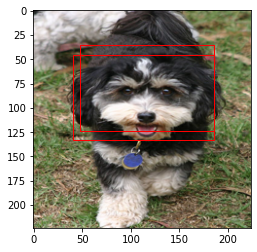

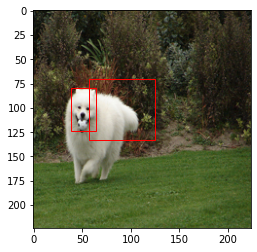

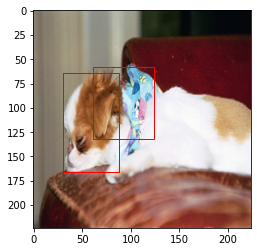

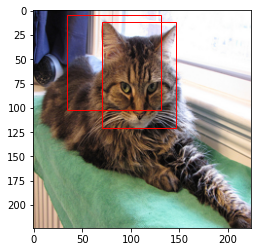

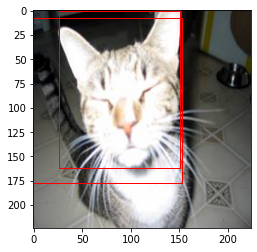

In [ ]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box

##### CODE HERE #####
idx = 0
for val_data, val_gt in val_dataset:
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)

    pred = model.predict(val_data)
    pred_x = pred[:, 0]
    pred_y = pred[:, 1]
    pred_w = pred[:, 2]
    pred_h = pred[:, 3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)

    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h, fill=False, color='red')
    plt.axes().add_patch(pred_rect)

    plt.imshow(val_data[idx])
    plt.show()

### 문제 13. IoU 계산하기

    - validation set에 대하여 average IoU를 계산해봅시다.
    - 모든 validation set data에 대하여 각각 IoU를 계산하여 average를 계산합니다.

In [ ]:
## IOU 계산
avg_iou = 0
for val_data, val_gt in val_dataset:
    ##### CODE HERE #####
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_VAL_BATCH):
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        if xmin > pred_xmax or xmax < pred_xmin:
            continue
        if ymin > pred_ymax or ymax < pred_ymin:
            continue

        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
        inter = w_inter * h_inter
        union = (w[idx].numpy()*h[idx].numpy() + pred_w[idx]*pred_h[idx])*IMG_SIZE*IMG_SIZE - inter

        iou = inter / union
        avg_iou += iou / N_VAL
print(avg_iou)

0.5147338445159568


### 문제 14. pre-trained MobileNetV2로 Localization 학습하기

    - ImageNet data로 pre-training된 MobileNetV2를 불러와서 localization을 학습해봅시다.
    - Pretrained model은 tensorflow.keras.applications.mobilenet_v2.MobileNetV2를 불러와서 사용합니다.
    - global average pooling 이후의 layer는 자유롭게 구성해도 좋습니다.
    - loss는 MSE를 사용하고, optimizer나 learning rate 등은 자유롭게 구성해도 좋습니다.

In [33]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [35]:
## MobileNet V2의 pretrained model을 load
##### CODE HERE #####
mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [38]:
## localization을 위한 network
## mobilenet v2 구조에 fully connected layer 3개를 추가하고 마지막 layer는 4개의 node로 x,y,w,h를 예측하도록 함
def mv2_model():
    ##### CODE HERE #####
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    x = mobilenet(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    outputs = Dense(4, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    return model

model = mv2_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                           

In [39]:
def loss_fn(y_true, y_pred):
    return keras.losses.MeanSquaredError()(y_true, y_pred)

## learning rate scheduling(필요시), model.compile
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=N_TRAIN/N_BATCH*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [40]:
## Train!
##### CODE HERE #####
model.fit(train_dataset, epochs=N_EPOCHS, validation_data=val_dataset)

Epoch 1/40
75/75 [==============================] - 58s 504ms/step - loss: 0.0335 - val_loss: 0.1118
Epoch 2/40
75/75 [==============================] - 36s 461ms/step - loss: 0.0113 - val_loss: 0.1158
Epoch 3/40
75/75 [==============================] - 36s 462ms/step - loss: 0.0055 - val_loss: 0.0847
Epoch 4/40
75/75 [==============================] - 36s 461ms/step - loss: 0.0034 - val_loss: 0.0429
Epoch 5/40
75/75 [==============================] - 38s 466ms/step - loss: 0.0028 - val_loss: 0.0286
Epoch 6/40
75/75 [==============================] - 36s 460ms/step - loss: 0.0021 - val_loss: 0.0208
Epoch 7/40
75/75 [==============================] - 36s 460ms/step - loss: 0.0022 - val_loss: 0.0170
Epoch 8/40
75/75 [==============================] - 36s 462ms/step - loss: 0.0017 - val_loss: 0.0156
Epoch 9/40
75/75 [==============================] - 36s 459ms/step - loss: 0.0017 - val_loss: 0.0136
Epoch 10/40
75/75 [==============================] - 36s 459ms/step - loss: 0.0016 - val_lo

KeyboardInterrupt: ignored

### 문제 15. 학습 결과 확인

    - validation set에서 data를 5개 이상 뽑아서 예측값과 정답을 한꺼번에 출력해서 얼마나 학습이 잘 되었는지 확인해봅시다.

In [ ]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
##### CODE HERE #####
idx = 0
for val_data, val_gt in val_dataset:
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)

    pred = model.predict(val_data)
    pred_x = pred[:, 0]
    pred_y = pred[:, 1]
    pred_w = pred[:, 2]
    pred_h = pred[:, 3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)

    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h, fill=False, color='red')
    plt.axes().add_patch(pred_rect)

    plt.imshow(val_data[idx])
    plt.show()

### 문제 16. IoU 확인

    - validation set에 대하여 average IoU를 계산해봅시다.
    - 모든 validation set data에 대하여 각각 IoU를 계산하여 average를 계산합니다.

In [ ]:
## IOU 계산
avg_iou = 0
for val_data, val_gt in val_dataset:
    ##### CODE HERE #####
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_VAL_BATCH):
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        if xmin > pred_xmax or xmax < pred_xmin:
            continue
        if ymin > pred_ymax or ymax < pred_ymin:
            continue

        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
        inter = w_inter * h_inter
        union = (w[idx].numpy()*h[idx].numpy() + pred_w[idx]*pred_h[idx])*IMG_SIZE*IMG_SIZE - inter

        iou = inter / union
        avg_iou += iou / N_VAL
print(avg_iou)

## Step 4. Multi-task Learning을 활용하여 성능 개선하기

### 문제 17. Classification branch 추가하기

    - pre-trained MobileNetV2의 한 쪽에 개/고양이 2개 class를 구분하는 classification branch를 추가해봅시다.
    - 앞의 경우와 마찬가지로 classification branch도 global average pooling 이후의 network은 자유롭거 구성해도 좋습니다.
    - classification label을 추가하가 위하여 tfrecord file을 parsing하는 function부터 수정이 필요합니다.
    - train_dataset, val_dataset도 재생성합니다.

In [ ]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),              
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.
    
    cls_num = tf.cast(parsed_features['cls_num'], tf.float32)
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([cls_num, x, y, w, h], -1)
    
    return image, gt

In [ ]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH)

In [ ]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(N_VAL_BATCH)

In [ ]:
def create_multitask_model():
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)

    dense_b1_1 = Dense(256)(gap)
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)
    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)
    output1 = Dense(2, activation='softmax')(relu_b1_6)

    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)
    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)
    output2 = Dense(4, activation='sigmoid')(relu_b2_6)

    concat = Concatenate()([output1, output2])

    return keras.Model(inputs=mobilenetv2.input, outputs=concat)

In [ ]:
model = create_multitask_model()
model.summary()

### 문제 18. Loss function 만들고 학습하기

    - localization branch에는 MSE를 그대로 사용하고, classification branch에 cross-entropy loss를 추가해봅시다.
    - 두 개의 loss를 적당한 비율로 더하여 전체 loss를 구성합니다.
    - 많은 경우에 classification 보다 localization loss에 가중치를 좀 더 크게주는 것이 좋습니다.
    - 이전 model들과 마찬가지로 learning rate과 optimizer를 결정하고 model을 학습해봅시다.

In [ ]:
def loss_fn(y_true, y_pred):
    cls_labels = tf.cast(y_true[:,:1], tf.int64)
    loc_labels = y_true[:,1:]
    cls_preds = y_pred[:,:2]
    loc_preds = y_pred[:,2:]
    cls_loss = keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)
    loc_loss = keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    return cls_loss + 5*loc_loss

In [ ]:
## learning rate scheduling(필요시), model.compile
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=N_TRAIN/N_BATCH*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [ ]:
## Train!
model.fit(train_dataset, epochs=N_EPOCHS, validation_data=val_dataset)

### 문제 19. 학습 결과 확인

    - validation set에서 data를 5개 이상 뽑아서 예측값과 정답을 한꺼번에 출력해서 얼마나 학습이 잘 되었는지 확인해봅시다.

In [ ]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
for val_data, val_gt in val_dataset:
  x = val_gt[:,1]
  y = val_gt[:,2]
  w = val_gt[:,3]
  h = val_gt[:,4]
  xmin = x[idx].numpy() - w[idx].numpy()/2.
  ymin = y[idx].numpy() - h[idx].numpy()/2.
  rect_x = int(xmin * IMG_SIZE)
  rect_y = int(ymin * IMG_SIZE)
  rect_w = int(w[idx].numpy() * IMG_SIZE)
  rect_h = int(h[idx].numpy() * IMG_SIZE)

  rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
  plt.axes().add_patch(rect)

  prediction = model.predict(val_data)
  pred_x = prediction[:,2]
  pred_y = prediction[:,3]
  pred_w = prediction[:,4]
  pred_h = prediction[:,5]
  pred_xmin = pred_x[idx] - pred_w[idx]/2.
  pred_ymin = pred_y[idx] - pred_h[idx]/2.
  pred_rect_x = int(pred_xmin * IMG_SIZE)
  pred_rect_y = int(pred_ymin * IMG_SIZE)
  pred_rect_w = int(pred_w[idx] * IMG_SIZE)
  pred_rect_h = int(pred_h[idx] * IMG_SIZE)

  pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                        fill=False, color='blue')
  plt.axes().add_patch(pred_rect)

  plt.imshow(val_data[idx])
  plt.show()

### 문제 20. IoU 확인

    - validation set에 대하여 average IoU를 계산해봅시다.
    - 모든 validation set data에 대하여 각각 IoU를 계산하여 average를 계산합니다.
    - 이전 model들과 결과를 비교하여 classification branch가 성능 향상에 도움이 되었는지 확인해봅시다.

In [ ]:
## IOU 계산
avg_iou = 0
for val_data, val_gt in val_dataset:
  x = val_gt[:,1]
  y = val_gt[:,2]
  w = val_gt[:,3]
  h = val_gt[:,4]
  prediction = model.predict(val_data)
  pred_x = prediction[:,2]
  pred_y = prediction[:,3]
  pred_w = prediction[:,4]
  pred_h = prediction[:,5]
  for idx in range(N_VAL_BATCH):
    xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
    ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
    xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
    ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

    pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
    pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
    pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
    pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

    if xmin > pred_xmax or xmax < pred_xmin:
      continue
    if ymin > pred_ymax or ymax < pred_ymin:
      continue

    w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
    h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
    inter = w_inter * h_inter
    union = (w[idx].numpy()*h[idx].numpy() + pred_w[idx]*pred_h[idx])*IMG_SIZE*IMG_SIZE - inter

    iou = inter / union
    avg_iou += iou / N_VAL

print(avg_iou)

### 문제 21. 새로운 image로 test하기

    - 인터넷에서 개나 고양이의 사진을 다운받아서, 학습된 model에 넣고 제대로 localization이 되는지 확인해봅시다.
    - image size를 224x224로 resize하고 픽셀 값을 225로 나누는 preprocessing은 동일하게 적용합니다.
    - CNN은 4차원의 입력을 가지므로, 입력 image를 4차원으로 확장하는 과정이 필요합니다.
    - localization 결과를 화면에 출력하여 직접 확인해봅시다.

In [ ]:
##### CODE HERE #####